In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter15-TF"
unique_name = "RoBERTa_Finetuned_with_TopTermsVectors"
tvt_set = "tvt2_3"

terms_limit = 750

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Twitter15-TF_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(742, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15-tf_dataset.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1,tvt2_2,tvt2_3
0,551099691702956032,rip elly may clampett: so sad to learn #beverl...,True,training,validation,training,training
1,514106273852174337,just in: missing afghan soldiers found trying ...,True,training,training,training,testting
2,495366618818830336,#riphulkhogan my heart is ripping like your sh...,False,training,testting,validation,training
3,532206910796468224,a chick-fil-a manager allegedly banned this hi...,False,validation,training,training,training
4,560187970389819392,islamic tribunal using sharia law in texas has...,False,validation,training,validation,validation


In [4]:
label_type = "label"
labels_str = data[label_type].unique().tolist()
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d[label_type])
    labels.append([lab])
labels[:10]

[[0], [0], [1], [1], [1], [1], [1], [1], [0], [1]]

In [6]:
vector_terms = []
with open("../../data/processed/twitter15-tf_best_terms.txt", "r") as f:
    for t in f.readlines():
        vector_terms.append(t.strip())

print(vector_terms[:10])
len(vector_terms)

['michael brown', 'kkk wednesday', 'saudi cleric', "paul walker's", 'new audio', 'parliament hill', 'in a', 'fanged deer', 'paul walker', 'beheading of']


750

In [7]:
import string
import nltk
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(reduce_len=True)


def text2unigrams(text):
    text = tokenizer.tokenize(text.encode('ascii', 'ignore').decode('utf8'))
    text = [t for t in text if t not in string.punctuation]
    text = [t for t in text if t not in ['URL', '‘', '’']]
    
    return text


def text2bigrams(text):
    text = tokenizer.tokenize(text.encode('ascii', 'ignore').decode('utf8'))
    text = [t for t in text if t not in string.punctuation]
    text = [t for t in text if t not in ['URL', '‘', '’']]
    
    bigrams = nltk.bigrams(text)
    bigrams = map(' '.join, bigrams)
    bigrams = [bgr for bgr in bigrams]
    
    return bigrams


def text2trigrams(text):
    text = tokenizer.tokenize(text.encode('ascii', 'ignore').decode('utf8'))
    text = [t for t in text if t not in string.punctuation]
    text = [t for t in text if t not in ['URL', '‘', '’']]
    
    trigrams = nltk.trigrams(text)
    trigrams = map(' '.join, trigrams)
    trigrams = [bgr for bgr in trigrams]
    
    return trigrams


def bigrams_vectors_generation(texts):
    bigram_vectors = []
    for text in texts:
        bigrams = text2bigrams(text)

        init_vec = [0.0 for _ in range(len(bigram_vector_base) + 1)]
        for bgr in bigrams:
            if bgr in bigram_vector_base:
                idx = bigram_vector_base.index(bgr)
                init_vec[idx] = 1.0
            else:
                init_vec[-1] = 1.0
        bigram_vectors.append(init_vec)
    
    return bigram_vectors


def custom_vectors_generation(texts, vector_terms):
    vectors = []
    for text in texts:
        bigrams = text2bigrams(text)
        trigrams = text2trigrams(text)

        init_vec = [0.0 for _ in range(len(vector_terms) + 1)]
        for bgr in bigrams:
            if bgr in vector_terms:
                idx = vector_terms.index(bgr)
                init_vec[idx] = 1.0
            else:
                init_vec[-1] = 1.0
        for tgr in trigrams:
            if tgr in vector_terms:
                idx = vector_terms.index(tgr)
                init_vec[idx] = 1.0
            else:
                init_vec[-1] = 1.0
        vectors.append(init_vec)
    
    return vectors

In [8]:
texts = data['tweet_text'].tolist()
terms_vectors = custom_vectors_generation(texts, vector_terms)

vectors = np.concatenate([vectors, terms_vectors], axis=1)
vectors = vectors.reshape(vectors.shape[0], vectors.shape[1], 1)
vectors.shape

(742, 1519, 1)

In [9]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d[tvt_set] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d[tvt_set] == 'testting'])

In [10]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(488, 1519, 1)
(184, 1519, 1)
(70, 1519, 1)
(488, 1)
(184, 1)
(70, 1)


In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNClassifier(nn.Module):
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(n_input, 512, 1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 128, 1, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=1, stride=2),
            nn.Flatten(),
            nn.Linear(128, n_output),
            nn.Sigmoid()
        )
        self.criterion = criterion()
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

    def forward(self, input):
        return self.model(input)
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        binary: bool = False,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        best_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
                
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                
                try:
                    loss = self.criterion(outputs, targets)
                except Exception:
                    loss = self.criterion(outputs, targets.long())

                test_loss += loss.item()
                
                preds = self.predict(test_x, binary=binary)
                if binary:
                    preds = np.array([p[0] for p in preds.cpu().numpy()])
                    label_target = np.array([v[0] for v in test_y])
                else:
                    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()])
                    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y])
                
                conf_mat = ConfusionMatrix(
                    labels=label_target,
                    predictions=preds,
                    binary=binary
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x, binary=False):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            
            if binary:
                return preds
            else:
                _, preds = torch.max(preds, dim = 1)
                return preds

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 86.413
Saving after new best accuracy : 88.043
Saving after new best accuracy : 88.587
-- Epoch 50, Train Loss : 0.16404397785663605, Test Loss : 0.28945237398147583
Saving after new best accuracy : 89.13
Saving after new best accuracy : 89.674
-- Epoch 100, Train Loss : 0.10922075062990189, Test Loss : 0.23864760994911194
Saving after new best accuracy : 90.217
Saving after new best accuracy : 90.761
Saving after new best accuracy : 91.304
-- Epoch 150, Train Loss : 0.06112892925739288, Test Loss : 0.21139079332351685
-- Epoch 200, Train Loss : 0.03766460344195366, Test Loss : 0.23073710501194
-- Epoch 250, Train Loss : 0.027493460103869438, Test Loss : 0.26492583751678467
-- Epoch 300, Train Loss : 0.02242676541209221, Test Loss : 0.3004702031612396
-- Epoch 350, Train Loss : 0.019346510991454124, Test Loss : 0.33393391966819763
-- Epoch 400, Train Loss : 0.01711984910070896, Test Loss 

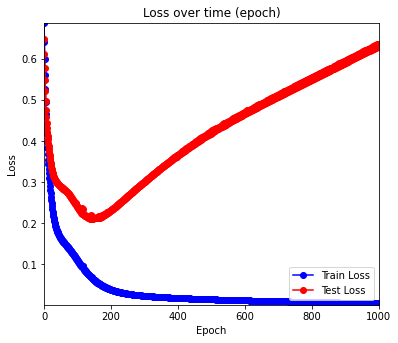

Exec Time : 12.91 seconds

Validation Set
Predictions : torch.Size([184, 1])
Binary Class Evaluation

True Positive : 86
False Positive : 11
False Negative : 5
True Negative : 82

Class False Evaluation
- Precision : 88.66 %
- Recall : 94.505 %
- F1 : 0.91489

Class True Evaluation
- Precision : 94.253 %
- Recall : 88.172 %
- F1 : 0.91111

Combined Evaluation
- Accuracy : 91.304 %
- Precision : 91.456 %
- Recall : 91.339 %
- F1 : 0.91397
- Average Confidence : 84.66 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_1DCNN_RoBERTa_Finetuned_with_TopTermsVectors Validation, 91.304, 91.456, 91.339, 0.91397, 88.66, 94.505, 0.91489, 94.253, 88.172, 0.91111, 

Test Set
Predictions : torch.Size([70, 1])
Binary Class Evaluation

True Positive : 33
False Positive : 3
False Negative : 4
True Negative : 30

Class False Evaluation
- Precision : 91.667 %
- Recall : 89.189 %
- F1 : 0.90411

Class True Evaluation
- Precision : 88.235 %
- Recall : 90.909 %
- F1 : 0.89552

Combined Evaluation
- Accuracy

In [12]:
print("Multiclass Classification using 4-Layer Linear Network")
binary = True

start = time.time()
model_name = f"{dataset_name}_1DCNN_{unique_name}"
model = NNClassifier(train_vectors.shape[1], n_output=1, criterion=nn.BCELoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                binary=binary,
                saves=model_name,
                n_iter=1000,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nValidation Set")
preds = model.predict(val_vectors, binary=binary)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()
if binary:
    preds = np.array([p[0] for p in preds])
    label_target = np.array([v[0] for v in val_labels])
else:
    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()])
    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels])

conf_mat = ConfusionMatrix(
    labels=label_target,
    predictions=preds,
    binary=True,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\nTest Set")
preds = model.predict(test_vectors, binary=binary)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()
if binary:
    preds = np.array([p[0] for p in preds])
    label_target = np.array([v[0] for v in test_labels])
else:
    preds = np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()])
    label_target = np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels])

conf_mat = ConfusionMatrix(
    labels=label_target,
    predictions=preds,
    binary=True,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)